In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import time
from copy import deepcopy
%pylab inline
%env JOBLIB_TEMP_FOLDER=/tmp

Populating the interactive namespace from numpy and matplotlib
env: JOBLIB_TEMP_FOLDER=/tmp


In [2]:
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, StratifiedShuffleSplit, cross_val_score, cross_val_predict, GridSearchCV, LeaveOneOut
from sklearn.feature_selection import SelectFromModel, VarianceThreshold, SelectKBest, f_classif, chi2
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, confusion_matrix
from sklearn.preprocessing import Imputer, StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.pipeline import Pipeline
from scipy import stats
from sklearn.externals import joblib
from collections import Counter

/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
import warnings
warnings.filterwarnings("ignore")

# Classification

In [4]:
# отбор признаков на основе модели
# аналогично SelectFromModel, но на основе количества признаков, а не порога

from sklearn.base import BaseEstimator, MetaEstimatorMixin, clone
from sklearn.feature_selection.base import SelectorMixin
from sklearn.feature_selection.from_model import _get_feature_importances
from sklearn.utils.metaestimators import if_delegate_has_method

class SelectNFeaturesFromModel(BaseEstimator, SelectorMixin, MetaEstimatorMixin):
    def __init__(self, estimator, n_selected, prefit=False):
        self.estimator = estimator
        self.n_selected = n_selected
        self.prefit = prefit

    def _get_support_mask(self):
        if self.prefit:
            estimator = self.estimator
        elif hasattr(self, 'estimator_'):
            estimator = self.estimator_
        else:
            raise ValueError(
                'Either fit SelectFromModel before transform or set "prefit='
                'True" and pass a fitted estimator to the constructor.')
        scores = _get_feature_importances(estimator)
        threshold = np.sort(scores)[-self.n_selected]
        return scores >= threshold

    def fit(self, X, y=None, **fit_params):
        if self.prefit:
            raise NotFittedError(
                "Since 'prefit=True', call transform directly")
        self.estimator_ = clone(self.estimator)
        self.estimator_.fit(X, y, **fit_params)
        return self
    
    @property
    def scores_(self):
        scores = _get_feature_importances(self.estimator_,)
        return scores

    @property
    def threshold_(self):
        scores = _get_feature_importances(self.estimator_,)
        return np.sort(scores)[-n_selected]
    
    @if_delegate_has_method('estimator')
    def partial_fit(self, X, y=None, **fit_params):
        if self.prefit:
            raise NotFittedError(
                "Since 'prefit=True', call transform directly")
        if not hasattr(self, "estimator_"):
            self.estimator_ = clone(self.estimator)
        self.estimator_.partial_fit(X, y, **fit_params)
        return self

In [5]:
from sklearn.base import BaseEstimator, MetaEstimatorMixin, clone
from sklearn.feature_selection.base import SelectorMixin
from sklearn.feature_selection.from_model import _get_feature_importances
from sklearn.utils.metaestimators import if_delegate_has_method

class SelectFromGroups(BaseEstimator, SelectorMixin, MetaEstimatorMixin):
    # groups = True-False-mask for X columns (features)
    def __init__(self, method, groups=[]):
        self.method = method
        self.groups = groups
        self.methods = []
        self.supports = []
        
    def _get_support_mask(self):
#         if self.prefit:
#             estimator = self.estimator
#         elif hasattr(self, 'estimator_'):
#             estimator = self.estimator_
#         else:
#             raise ValueError(
#                 'Either fit SelectFromModel before transform or set "prefit='
#                 'True" and pass a fitted estimator to the constructor.')
#         scores = _get_feature_importances(estimator)
#         threshold = np.sort(scores)[-self.n_selected]
        return np.column_stack(supports)
        
    def fit(self, X, y):
        self.methods = []
        self.supports = []
        if not self.groups:
            n_features = X.shape[1]
            self.groups = [np.ones(n_features, dtype=bool)]
        for group in self.groups:
            self.method.fit(X[:, group], y)
            self.methods.append(deepcopy(self.method))
            self.supports.append(self.method.get_support())
                
    def fit_transform(self, X, y):
        self.methods = []
        self.supports = []
        transformed = []
        if not self.groups:
            n_features = X.shape[1]
            self.groups = [np.ones(n_features, dtype=bool)]
        for group in self.groups:
            transformed.append(self.method.fit_transform(X[:, group], y))
            self.methods.append(deepcopy(self.method))
            self.supports.append(self.method.get_support())
                
        return np.column_stack(transformed)
    def transform(self, X):
        transformed = []
        if not self.methods:
            self.method.transform(X)
        else:
            for group in self.groups:
                transformed.append(self.method.transform(X[:, group]))
        return np.column_stack(transformed)

In [6]:
def get_svc_grid(cv, dim_reduction_methods, scoring, random_state=None, n_jobs=1,
                 svc_kernel_l=None, svc_c_l=None, svc_gamma_l=None):

    pipe = Pipeline([
        ("Fill_NaN", Imputer(strategy="median")),
        ('StdScaler', StandardScaler()),
#         ("VarTh", VarianceThreshold()),
        ('dim_reduction', SelectKBest(stats.ttest_ind)),
        ('classifier', SVC(probability=True, random_state=random_state)),
    ])

    param_grid = {
        'dim_reduction': dim_reduction_methods,
    }
    if svc_kernel_l is not None:
        param_grid['classifier__kernel'] = svc_kernel_l
    if svc_c_l is not None:
        param_grid['classifier__C'] = svc_c_l
    if svc_gamma_l is not None:
        param_grid['classifier__gamma'] = svc_gamma_l
    
    return GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scoring, cv=cv, n_jobs=n_jobs)

In [7]:
def get_lr_grid(cv, dim_reduction_methods, scoring, random_state=None, n_jobs=1,
                 lr_c_l=None, lr_penalty_l=None):
    
    pipe = Pipeline([
        ("Fill_NaN", Imputer(strategy="median")),
        ('StdScaler', StandardScaler()),
#         ("VarTh", VarianceThreshold()),
        ('dim_reduction', SelectKBest(stats.ttest_ind)),
        ('classifier', LogisticRegression(random_state=random_state)),
    ])

    param_grid = {
        'dim_reduction': dim_reduction_methods,
    }
    if lr_c_l is not None:
        param_grid['classifier__C'] = lr_c_l
    if lr_penalty_l is not None:
        param_grid['classifier__penalty'] = lr_penalty_l
    
    return GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scoring, cv=cv, n_jobs=n_jobs)

In [8]:
def get_rfc_grid(cv, dim_reduction_methods, scoring, random_state=None, n_jobs=1,
                 rfc_n_estimators_l=None):
    
    pipe = Pipeline([
        ("Fill_NaN", Imputer(strategy="median")),
        ('StdScaler', StandardScaler()),
#         ("VarTh", VarianceThreshold()),
        ('dim_reduction', SelectKBest(stats.ttest_ind)),
        ('classifier', RandomForestClassifier(random_state=random_state)),
    ])

    param_grid = {
        'dim_reduction': dim_reduction_methods,
    }
    if rfc_n_estimators_l is not None:
        param_grid['classifier__n_estimators'] = rfc_n_estimators_l
    
    return GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scoring, cv=cv, n_jobs=n_jobs)

In [9]:
def get_knn_grid(cv, dim_reduction_methods, scoring, random_state=None, n_jobs=1,
                 knn_n_neighbors_l=None, knn_weights_l=None, knn_p_l=None):
    
    pipe = Pipeline([
        ("Fill_NaN", Imputer(strategy="median")),
        ('StdScaler', StandardScaler()),
#         ("VarTh", VarianceThreshold()),
        ('dim_reduction', SelectKBest(stats.ttest_ind)),
        ('classifier', KNeighborsClassifier()),
    ])

    param_grid = {
        'dim_reduction': dim_reduction_methods,
    }
    if knn_n_neighbors_l is not None:
        param_grid['classifier__n_neighbors'] = knn_n_neighbors_l
    if knn_weights_l is not None:
        param_grid['classifier__weights'] = knn_weights_l
    if knn_p_l is not None:
        param_grid['classifier__p'] = knn_p_l
    
    return GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scoring, cv=cv, n_jobs=n_jobs)

In [10]:
def get_gbc_grid(cv, dim_reduction_methods, scoring, random_state=None, n_jobs=1,
                 gbc_n_estimators_l=None): # мб нужно варьировать больше параметров
    
    pipe = Pipeline([
        ("Fill_NaN", Imputer(strategy="median")),
        ('StdScaler', StandardScaler()),
#         ("VarTh", VarianceThreshold()),
        ('dim_reduction', SelectKBest(stats.ttest_ind)),
        ('classifier', GradientBoostingClassifier(random_state=random_state)),
    ])

    param_grid = {
        'dim_reduction': dim_reduction_methods,
    }
    if gbc_n_estimators_l is not None:
        param_grid['classifier__n_estimators'] = gbc_n_estimators_l
    
    return GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scoring, cv=cv, n_jobs=n_jobs)

In [11]:
# set printoptions
pd.set_option('expand_frame_repr', True)
pd.set_option('max_colwidth', 150)

In [12]:
def print_results(clf_grid_dict, save_plot_to=None):
    results = {
            "classifier" : [], 
            "best parameters" : [],
            "best dim. reduction method" : [],
            "mean" : [],
            "std" : []
           }
    
    for clf, grid in clf_grid_dict.items():
        results["classifier"].append(clf)
        results["best parameters"].append(", ".join(
            [param + " = " + str(best_value) for param, best_value in grid.best_params_.items() if param != 'dim_reduction']))
        results["best dim. reduction method"].append(grid.best_params_['dim_reduction'])
        idx = grid.best_index_
        results["mean"].append(grid.cv_results_['mean_test_score'][idx])
        results["std"].append(grid.cv_results_['std_test_score'][idx])
        
    results = pd.DataFrame(results, columns=["classifier", "best parameters", "best dim. reduction method", "mean", "std"])
    display(results.set_index("classifier"))
    
    # draw graph
    width = 0.9
    for i in results.index:
        plt.bar(i, results.loc[i, "mean"], width, yerr=results.loc[i, "std"], label=results.loc[i, "classifier"])
    plt.xticks(range(results.shape[0]), results.loc[:, "classifier"])
    plt.axis(ymin=0.0, ymax=1.0)
    if save_plot_to is not None:
        plt.savefig(save_plot_to)
    plt.show()
    
    print("Best model: ")
    clf = results.loc[results["mean"].argmax(), "classifier"]
    print(clf)
    print("\n".join(
            [param + " = " + str(best_value) for param, best_value in clf_grid_dict[clf].best_params_.items()]))

### Объединенный подсчет и сравнение всех классификаторов (SVC, LR, RFC, KNN, GBC)

In [13]:
def train_grid_cv(X, y, n_splits, n_repeats, scoring, pos_label=None, random_state=None, n_jobs=1, features_groups=[], save_plot_to=None):
    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)
    
    n_features = [10, 20, 50, 100]
    n_components = [10, 20]
    
    # list of dimensionality reduction methods
    dim_reduction_methods = []
    dim_reduction_methods += [SelectKBest(stats.ttest_ind, n) for n in n_features]
    dim_reduction_methods += [SelectKBest(f_classif, n) for n in n_features]
    dim_reduction_methods += [SelectNFeaturesFromModel(RandomForestClassifier(n_estimators=100, random_state=random_state), n) for n in n_features]
    dim_reduction_methods += [SelectNFeaturesFromModel(LogisticRegression(random_state=random_state), n) for n in n_features]
    dim_reduction_methods += [SelectNFeaturesFromModel(ExtraTreesClassifier(n_estimators=100, random_state=random_state), n) for n in n_features]
    dim_reduction_methods += [PCA(n, random_state=random_state) for n in n_components]
    dim_reduction_methods += [LocallyLinearEmbedding(n_components=n, random_state=random_state) for n in n_components]
    
    
    print("Target distribution: ")
    print(y.value_counts(), "\n")
    if pos_label is None:
        y_enc = pd.Series(LabelEncoder().fit_transform(y), index=y.index)
    else:
        y_enc = pd.Series(y == pos_label, dtype=int)
    
    print("Training SVC...")
    grid_cv_svc = get_svc_grid(cv, dim_reduction_methods, scoring, random_state=random_state, n_jobs=n_jobs,
                               svc_kernel_l=["rbf", "linear"],
                               svc_c_l=[10 ** i for i in range(0, 4, 1)],
                               svc_gamma_l=[10 ** i for i in range(-3, -1, 1)])
    start_time = time.time()
    grid_cv_svc.fit(X, y_enc)
    print("(training took {}s)\n".format(time.time() - start_time))
    
    print("Training LR...")
    grid_cv_lr = get_lr_grid(cv, dim_reduction_methods, scoring, random_state=random_state, n_jobs=n_jobs,
                             lr_c_l=[10 ** i for i in range(-4, -1, 1)],
                             lr_penalty_l=["l1", "l2"])
    start_time = time.time()
    grid_cv_lr.fit(X, y_enc)
    print("(training took {}s)\n".format(time.time() - start_time))
    
    print("Training RFC...")
    grid_cv_rfc = get_rfc_grid(cv, dim_reduction_methods, scoring, random_state=random_state, n_jobs=n_jobs,
                               rfc_n_estimators_l=[i for i in range(100, 210, 30)])
    start_time = time.time()
    grid_cv_rfc.fit(X, y_enc)
    print("(training took {}s)\n".format(time.time() - start_time))
    
    print("Training KNN...")
    class_size_tr = min(y.value_counts())
    grid_cv_knn = get_knn_grid(cv, dim_reduction_methods, scoring, random_state=random_state, n_jobs=n_jobs,
                              knn_p_l=[1, 2],
                              knn_weights_l=["uniform", "distance"],
                              knn_n_neighbors_l=[i for i in range(5, class_size_tr - 1, 3)])
    start_time = time.time()
    grid_cv_knn.fit(X, y_enc)
    print("(training took {}s)\n".format(time.time() - start_time))

    
    print("Scoring:", scoring)
    print_results({
        "SVC" : grid_cv_svc,
        "LR" : grid_cv_lr,
        "RFC" : grid_cv_rfc,
        "KNN" : grid_cv_knn,
                  }, save_plot_to=save_plot_to)
    
    best_model = max([grid_cv_svc, grid_cv_lr, grid_cv_rfc, grid_cv_knn], key=lambda x: x.best_score_).best_estimator_
    
    return best_model, grid_cv_svc, grid_cv_lr, grid_cv_rfc, grid_cv_knn

In [18]:
def repeated_cross_val_predict(estimator, X, y, cv, file=None):
    predictions = [[] for i in range(n_objects)]
    for idx_tr, idx_te in tqdm(cv.split(X, y)):
        estimator.fit(X.iloc[idx_tr], y.iloc[idx_tr])
        pred_te = np.array(estimator.predict(X.iloc[idx_te]), dtype=int)
        for i, idx in enumerate(idx_te):
            predictions[X.index[idx]].append(idx_to_label[pred_te[i]])
        
    predictions = pd.DataFrame(predictions)
    if file is not None:
        predictions.to_csv(file)
        
    return predictions

In [19]:
def repeated_cross_val_predict_proba(estimator, X, y, cv, pos_label=None, file=None):
    
    if pos_label is None:
        y_enc = pd.Series(LabelEncoder().fit_transform(y), index=y.index)
    else:
        y_enc = pd.Series(y == pos_label, dtype=int)
    predictions = [[] for i in range(n_objects)]
    for idx_tr, idx_te in tqdm(cv.split(X, y_enc)):
        estimator.fit(X.iloc[idx_tr], y_enc.iloc[idx_tr])
        pred_te = np.array(estimator.predict_proba(X.iloc[idx_te]), dtype=float)
        for i, idx in enumerate(idx_te):
            predictions[X.index[idx]].append(pred_te[i, 1])
        
    predictions = pd.DataFrame(predictions)
    if file is not None:
        predictions.to_csv(file)
        
    return predictions

In [20]:
def save_model(model, file):
    joblib.dump(model, file)
    
def load_model(file):
    model = joblib.load(file)
    return model

In [21]:
def plot_roc_curve(y, probas, idx, average_repeats=False, show=True):
    if average_repeats:
        y_true = y
        y_score = probas[idx].mean(axis=1)
    else:
        n_repeats = probas.shape[1]
        y_true = pd.Series(np.tile(y, (n_repeats)), dtype=int)
        y_score = probas[idx].values.T.reshape(-1, 1)
    fpr, tpr, t = roc_curve(y_true=y_true, y_score=y_score)
    
    if show:
        plt.figure(figsize=(12, 8))
        plt.plot(fpr, tpr)
        plt.xlabel("False Positive rate", fontsize=14)
        plt.ylabel("True Positive rate", fontsize=14)
        plt.show()
        print("auc =", roc_auc_score(y_true, y_score))
        
    return fpr, tpr, t

In [22]:
def get_fixed_fpr_threshold(fpr, t, fix_fpr=0):
    return t[fpr <= fix_fpr][-1]

In [23]:
def get_fpr_fnr(fpr, tpr, fix_fpr_l=[0.1, 0.15, 0.2, 0.3]):
    fnr_l = []
    for fix_fpr in fix_fpr_l:
        fnr_l.append(1 - tpr[fpr <= fix_fpr][-1])
    fpr_fnr_table = pd.DataFrame(np.column_stack((fix_fpr_l, fnr_l)), columns=["False Positive rate (fixed)", "False Negative rate"])
    display(fpr_fnr_table)
    return fpr_fnr_table

In [24]:
# сейчас работает только для одномерных векторов вероятностей (одно предсказание для каждого объекта, напр. leave one out)
def get_incorrectly_classified(y, probas, idx, fpr, t, fix_fpr_l=[0.1, 0.15, 0.2, 0.3], file=None, show=True):
    columns = ["False Positive rate (fixed)", "Threshold", "False Positives indexes", "False Negatives indexes"]
    t_l = []
    false_0 = []
    false_1 = []
    for fix_fpr in fix_fpr_l:
        fix_t = t[fpr <= fix_fpr][-1]
        t_l.append(fix_t)
        labels_t = probas > fix_t
        labels_t = pd.Series(labels_t.values.ravel())
        false_0.append(", ".join(list(labels.loc[(probas[idx][np.logical_and(labels_t[idx] == 0, y == 1)]).index, "patient_number"])))
        false_1.append(", ".join(list(labels.loc[(probas[idx][np.logical_and(labels_t[idx] == 1, y == 0)]).index, "patient_number"])))
              
    t_l = np.array(t_l)
    false_0 = np.array(false_0)
    false_1 = np.array(false_1)
    
    res = pd.DataFrame(np.column_stack((fix_fpr_l, t_l)), columns=columns[:2])
    res["False Positives indexes"] = false_1
    res["False Negatives indexes"] = false_0
    
    if file is not None:
        res.to_csv(file)
        
    if show:
        display(res)
    return res

In [25]:
def get_features(X, y, model):
    model.fit(X, y)
#     var_th = model.named_steps['VarTh']
#     var_th_features_idx = var_th.get_support()
    dim_reduction = model.named_steps["dim_reduction"]
    features_idx = dim_reduction.get_support()
#     classifier = model.named_steps["classifier"]
#     features_weights = classifier.coef_[0]
    features = X.columns[features_idx].tolist()
    return features

In [26]:
def get_feature_sets_on_cross_val(X, y, model, cv):
    feature_sets = []
    for idx_tr, idx_te in tqdm(cv.split(X, y)):
        X_tr = X.loc[X.index[idx_tr]]
        y_tr = y.loc[X.index[idx_tr]]
        y_te = y.loc[X.index[idx_te]]
        feature_sets.append(get_features(X_tr, y_tr, model))
    return feature_sets

In [27]:
def get_frequent_features(features_l, classifier_l, y, p=0.5, min_common=3, file_all=None, file_frequent=None):
    for i, features in enumerate(features_l):
        features["frequency_norm"] = features["frequency"] / y.size
        features["classifier"] = classifier_l[i]
    
    all_features = pd.concat([features.drop("frequency", axis=1) for features in features_l], axis=0)
    all_features = all_features.reset_index().set_index("classifier")
    all_features.columns = ["feature", "frequency_norm"]
    
    if file_all is not None:
        all_features.to_csv(file_all)
        
    frequent_features = pd.DataFrame(all_features[all_features.frequency_norm > p]["feature"].value_counts())
    if file_frequent is not None:
        frequent_features.to_csv(file_frequent)
    
    common_frequent_features = frequent_features[frequent_features["feature"] >= min_common].index.tolist()
    
    return all_features, frequent_features, common_frequent_features

In [28]:
def get_frequent_indexes(probas_l, classifiers_l, y, idx, show=False, file=None):
    incorr_classified_l = []
    for i, probas in enumerate(probas_l):
        fpr, tpr, t = plot_roc_curve(y, probas, idx, show=show)
        incorr_classified = get_incorrectly_classified(y, probas, idx, fpr, t, show=show)
        incorr_classified["classifier"] = classifiers_l[i]
        incorr_classified_l.append(incorr_classified)
        
    all_incorr_classified = pd.concat(incorr_classified_l, axis=0)
    all_incorr_classified.set_index("classifier", inplace=True)
    
    if file is not None:
        all_incorr_classified.to_csv(file)
    
    max_fpr = all_incorr_classified["False Positive rate (fixed)"].max()
    common_false_positives = Counter(list((", ".join(all_incorr_classified[all_incorr_classified["False Positive rate (fixed)"] == max_fpr]["False Positives indexes"].tolist())).split(", ")))
    data=pd.DataFrame(common_false_positives,index=[0]).T
    common_false_positives_ =", ".join(data[data[0]>=3].index)    
    
    min_fpr = all_incorr_classified["False Positive rate (fixed)"].min()
    common_false_negatives = Counter(list((", ".join(all_incorr_classified[all_incorr_classified["False Positive rate (fixed)"] == min_fpr]["False Negatives indexes"].tolist())).split(", ")))
    data=pd.DataFrame(common_false_negatives,index=[0]).T
    common_false_negatives_ =", ".join(data[data[0]>=3].index)
    
    return all_incorr_classified, common_false_positives_, common_false_negatives_

In [29]:
def get_frequent_regions(all_features, n=0.0, importance=0.5):
    freq_list=all_features[all_features['frequency_norm']>=n]
    freq_list=freq_list.reset_index()
    freq_list['feature_pure']=''
    freq_list['feature_score']=''
    appendix_list_thick=['_NumVert','_GrayVol','_FoldInd','_CurvInd','_GausCurv','_ThickStd','_ThickAvg','_MeanCurv','_SurfArea']
    appendix_list_vol=['_Volume_mm3','_normMean','_normMin','_normMax','_normStdDev','_normRange','_NVoxels']
    for i in range(len(freq_list)):
        for j in appendix_list_thick:
            if j in freq_list['feature'].loc[i]:
                freq_list['feature_pure'].loc[i]=freq_list['feature'].loc[i].replace(j, '')
                freq_list['feature_score'].loc[i]=freq_list['frequency_norm'].loc[i]/9
        for k in appendix_list_vol:
            if k in freq_list['feature'].loc[i]:
                freq_list['feature_pure'].loc[i]=freq_list['feature'].loc[i].replace(k, '')
                freq_list['feature_score'].loc[i]=freq_list['frequency_norm'].loc[i]/7

    freq_pure_list=freq_list[['feature_pure','feature_score']].groupby(['feature_pure']).sum()
    freq_pure_list=freq_pure_list.sort_values(['feature_score'], ascending=False)
    freq_pure_list=freq_pure_list[freq_pure_list['feature_score']>=freq_pure_list['feature_score'].max()*importance]
    print (freq_pure_list)

In [30]:
# now going with test train validate
def select_features_on_cross_val(cv, X_tr, y_tr, random_state=None):
    # отбираем признаки    
    # сохраняем все признаки с весами (для каждой итерации RepeatedKFold)
    features_l = []
    for i_tr, i_te in cv.split(X_tr, y_tr):
        
        selector = SelectKBest(score_func=f_classif, k=150)
        selector.fit(X_tr.loc[X_tr.index[i_tr]], y_tr[X_tr.index[i_tr]])
        features_idx = selector.get_support()
        features = X_tr.columns[features_idx].tolist()
#         selector = LogisticRegression(penalty='l1', random_state=random_state)
#         selector.fit(X_tr.loc[X_tr.index[i_tr]], y_tr[X_tr.index[i_tr]])
#         features_weights = selector.coef_[0]
#         features = pd.DataFrame(sorted(list(zip(X_tr.columns, features_weights)), 
#                         key=lambda x: -abs(x[1])), columns=["feature", "weight (from classifier)"])
#         # оставляем только признаки с ненулевыми весами
#         features = features.loc[features["weight (from classifier)"] != 0, "feature"].values.tolist()
        features_l.append(features)

    # оставляем только признаки, которые вошли во все множества 
    selected_features = list(reduce(lambda x, y: set(x) & set(y), features_l))
#     print(selected_features)

    # оставляем области, которые вошли во все множества
    regions_l = list(map(lambda x: list(map(get_feature_region, x)), features_l))
    selected_regions = list(reduce(lambda x, y: set(x) & set(y), regions_l))
#     print(selected_regions)
    
    # выбираем все признаки для этих областей
    selected = []
    for region in selected_regions:
        for feature_type in types:
            feature = region + "_" + feature_type
            if feature in all_features:
                selected.append(feature)
    
    return selected

def cross_val_feature_selection_test(X, y, pos_label, estimator, n_splits_outer=5, n_repeats_outer=10, 
                                     n_splits=5, n_repeats=10, scoring="roc_auc", random_state=None):
    cv_outer = RepeatedStratifiedKFold(n_splits=n_splits_outer, n_repeats=n_repeats_outer, random_state=random_state)
    cv_score_tr = []
    score_te = []    
    # отложим часть данных для теста
    for idx_tr, idx_te in tqdm(cv_outer.split(X, y)):
        X_tr = X.loc[X.index[idx_tr]]
        X_te = X.loc[X.index[idx_te]]
        y_tr = y.loc[X.index[idx_tr]]
        y_te = y.loc[X.index[idx_te]]
        
        cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)
        selected = select_features_on_cross_val(cv, X_tr, y_tr, random_state)
        print(selected)
        
        # качество на той части выборки, где признаки были выбраны
        cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)
        scores_selected = cross_val_score(estimator, X_tr[selected], pd.Series(y_tr == pos_label, dtype=np.int), cv=cv, scoring=scoring)
        cv_score_tr += scores_selected.tolist()

        # test
        # обучаем на всей выборке (train) 
        estimator.fit(X_tr[selected], pd.Series(y_tr == pos_label, dtype=np.int))
        # оцениваем на отложенной части (test)
        score_selected_test = roc_auc_score(pd.Series(y_te == pos_label, dtype=np.int), estimator.predict_proba(X_te[selected])[:, 1])
        score_te.append(score_selected_test)
        
    return cv_score_tr, score_te

### Training

In [33]:
# some metrics (e.g. f1_score) can not be used for multiclass classification and require micro/macro averaging
# scoring, scoring_multiclass = "f1", "f1_micro"
classifiers_l = ["svc", "lr", "rfc", "knn"]
scoring = "roc_auc"
# other variants
# scoring, scoring_multiclass = "accuracy", "accuracy"

### BIPOLAR / control

In [31]:
mri_data = pd.read_csv('fmriprep_BIPOLAR_CONTROL.csv', index_col=0)
# mri_data = data[data.columns[:-1]]
mri_data.head()

,0,1,2,3,4,5,6,7,8,9,...,6661,6662,6663,6664,6665,6666,6667,6668,6669,target
0,0.905054,0.830627,0.791032,0.650030,0.726911,0.794661,0.785561,0.785303,0.416636,0.836273,...,0.819071,0.687870,0.327691,0.770494,0.737494,0.265930,0.677964,0.180462,0.528686,0
1,0.890581,0.806346,0.780677,0.262780,0.330473,0.798218,0.768104,0.638112,0.523704,0.714391,...,0.558997,0.139567,0.331483,0.574336,0.149787,0.375146,0.545059,0.539564,0.722114,0
2,0.816178,0.677894,0.392524,0.529311,0.275011,0.371895,0.020806,0.469636,0.326216,0.557980,...,0.640669,0.544715,0.014002,0.667235,0.385818,-0.022494,0.495472,0.093924,0.420528,0
3,0.807725,0.576972,0.699284,0.571747,0.646620,0.685664,0.762300,0.548918,0.586436,0.762267,...,0.637614,0.574696,0.365580,0.647420,0.596575,0.410199,0.851912,0.704787,0.691468,0
4,0.879808,0.671233,0.591219,0.555190,0.546275,0.640449,0.376038,0.399086,0.368852,0.688920,...,0.854777,0.657088,0.604125,0.766604,0.511823,0.446752,0.667355,0.634916,0.733674,0


Target distribution: 
0    122
1     49
Name: target, dtype: int64 

Training SVC...
(training took 6556.250585079193s)

Training LR...
(training took 146.55772423744202s)

Training RFC...
(training took 95.12706732749939s)

Training KNN...
(training took 2134.7394058704376s)

Scoring: roc_auc


,best parameters,best dim. reduction method,mean,std
classifier,,,,
RFC,classifier__n_estimators = 100,"SelectNFeaturesFromModel(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',\n max_depth=None, max_feat...",0.597208,0.095556
LR,"classifier__penalty = l1, classifier__C = 0.01","PCA(copy=True, iterated_power='auto', n_components=20, random_state=42,\n svd_solver='auto', tol=0.0, whiten=False)",0.622848,0.090198
KNN,"classifier__n_neighbors = 26, classifier__weights = uniform, classifier__p = 2","PCA(copy=True, iterated_power='auto', n_components=10, random_state=42,\n svd_solver='auto', tol=0.0, whiten=False)",0.642763,0.081944
SVC,"classifier__kernel = rbf, classifier__C = 100, classifier__gamma = 0.001","SelectKBest(k=100, score_func=<function f_classif at 0x7f1f267aa510>)",0.620336,0.088884


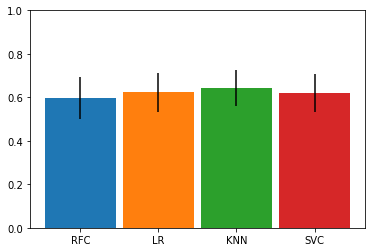

Best model: 
KNN
classifier__n_neighbors = 26
classifier__weights = uniform
dim_reduction = PCA(copy=True, iterated_power='auto', n_components=10, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)
classifier__p = 2


In [34]:
n_splits = 5
X, y = mri_data[mri_data.columns[:-1]], mri_data[mri_data.columns[-1]]

best_model_mri_S, grid_cv_svc_mri_S, grid_cv_lr_mri_S, grid_cv_rfc_mri_S, grid_cv_knn_mri_S= train_grid_cv(
    X, y, n_splits=n_splits, n_repeats=3, scoring=scoring, random_state=42, n_jobs=-1)

In [38]:
save_model(best_model_mri_S, "fMRI_fmriprep_best_BIPOLAR.pkl")

,best parameters,best dim. reduction method,mean,std
classifier,,,,
RFC,classifier__n_estimators = 100,"SelectNFeaturesFromModel(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',\n max_depth=None, max_feat...",0.597208,0.095556
LR,"classifier__penalty = l1, classifier__C = 0.01","PCA(copy=True, iterated_power='auto', n_components=20, random_state=42,\n svd_solver='auto', tol=0.0, whiten=False)",0.622848,0.090198
KNN,"classifier__n_neighbors = 26, classifier__weights = uniform, classifier__p = 2","PCA(copy=True, iterated_power='auto', n_components=10, random_state=42,\n svd_solver='auto', tol=0.0, whiten=False)",0.642763,0.081944
SVC,"classifier__kernel = rbf, classifier__C = 100, classifier__gamma = 0.001","SelectKBest(k=100, score_func=<function f_classif at 0x7f1f267aa510>)",0.620336,0.088884


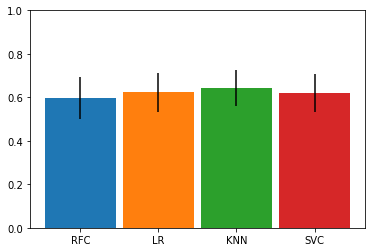

Best model: 
KNN
classifier__n_neighbors = 26
classifier__weights = uniform
dim_reduction = PCA(copy=True, iterated_power='auto', n_components=10, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)
classifier__p = 2


In [42]:
print_results({
        "SVC" : grid_cv_svc_mri_S,
        "LR" : grid_cv_lr_mri_S,
        "RFC" : grid_cv_rfc_mri_S,
        "KNN" : grid_cv_knn_mri_S,
                  }, save_plot_to='fmriprep_BIPOLAR_CONTROL.png')

### BIPOLAR / control aroma

In [39]:
mri_data = pd.read_csv('aroma_BIPOLAR_CONTROL.csv', index_col=0)
mri_data.head()

,0,1,2,3,4,5,6,7,8,9,...,6661,6662,6663,6664,6665,6666,6667,6668,6669,target
0,0.904770,0.829369,0.792125,0.653076,0.728872,0.794980,0.787377,0.787231,0.417565,0.836704,...,0.821399,0.687904,0.328590,0.774967,0.733535,0.268768,0.676869,0.178262,0.531821,0
1,0.891253,0.806560,0.781289,0.269488,0.334397,0.799294,0.768852,0.640816,0.525752,0.716471,...,0.557017,0.146031,0.336290,0.576098,0.158645,0.377989,0.548788,0.540977,0.727260,0
2,0.816769,0.677599,0.387493,0.527873,0.265885,0.370717,0.020080,0.449543,0.319015,0.559328,...,0.646365,0.545378,0.027825,0.671346,0.385499,-0.010096,0.493672,0.091793,0.427800,0
3,0.808305,0.571613,0.700602,0.572765,0.646205,0.686534,0.761346,0.552699,0.588374,0.762286,...,0.639721,0.574518,0.368526,0.650250,0.598606,0.415526,0.851607,0.705155,0.689314,0
4,0.879478,0.672525,0.591183,0.554872,0.548473,0.641077,0.376989,0.400039,0.367120,0.690383,...,0.855391,0.658596,0.602303,0.766093,0.515096,0.445765,0.670776,0.631877,0.731177,0


In [ ]:
n_splits = 5
X, y = mri_data[mri_data.columns[:-1]], mri_data[mri_data.columns[-1]]

best_model_mri_aB, grid_cv_svc_mri_aB, grid_cv_lr_mri_aB, grid_cv_rfc_mri_aB, grid_cv_knn_mri_aB= train_grid_cv(
    X, y, n_splits=n_splits, n_repeats=3, scoring=scoring, random_state=42, n_jobs=-1)

Target distribution: 
0    122
1     49
Name: target, dtype: int64 

Training SVC...
(training took 9717.726828098297s)

Training LR...
(training took 166.39950799942017s)

Training RFC...


In [ ]:
save_model(best_model_mri_aB, "fMRI_aroma_best_BIPOLAR.pkl")

,best parameters,best dim. reduction method,mean,std
classifier,,,,
RFC,classifier__n_estimators = 190,"SelectNFeaturesFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, ma...",0.597278,0.135462
LR,"classifier__penalty = l2, classifier__C = 0.01","SelectNFeaturesFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',\n max_depth=None, max_fe...",0.630221,0.112358
KNN,"classifier__n_neighbors = 29, classifier__weights = distance, classifier__p = 2","PCA(copy=True, iterated_power='auto', n_components=10, random_state=42,\n svd_solver='auto', tol=0.0, whiten=False)",0.638164,0.090795
SVC,"classifier__kernel = rbf, classifier__C = 10, classifier__gamma = 0.001","SelectNFeaturesFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',\n max_depth=None, max_fe...",0.645328,0.105587


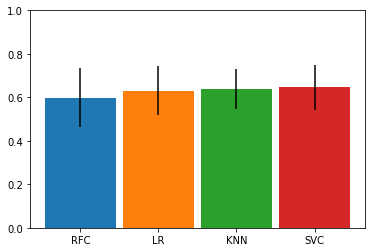

Best model: 
SVC
dim_reduction = SelectNFeaturesFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
             n_selected=100, prefit=False)
classifier__kernel = rbf
classifier__C = 10
classifier__gamma = 0.001


In [43]:
print_results({
        "SVC" : grid_cv_svc_mri_aB,
        "LR" : grid_cv_lr_mri_aB,
        "RFC" : grid_cv_rfc_mri_aB,
        "KNN" : grid_cv_knn_mri_aB,
                  }, save_plot_to='aroma_BIPOLAR_CONTROL.png')

### BIPOLAR / control openneuro

In [45]:
mri_data = pd.read_csv('openneuro_BIPOLAR_CONTROL.csv', index_col=0)
mri_data.head()

,0,1,2,3,4,5,6,7,8,9,...,6661,6662,6663,6664,6665,6666,6667,6668,6669,target
0,0.903161,0.840220,0.799509,0.610086,0.692490,0.802297,0.773570,0.780192,0.368664,0.832882,...,0.787642,0.643449,0.338068,0.675770,0.746291,0.280110,0.617764,0.096085,0.509282,0
1,0.909305,0.802791,0.838261,0.043383,0.082807,0.803068,0.809212,0.416151,0.442813,0.780733,...,0.616644,0.206885,0.176679,0.610826,0.264911,0.138920,0.441210,0.425356,0.471542,0
2,0.814521,0.659220,0.405604,0.478532,0.200010,0.442241,0.053502,0.349824,0.160864,0.540026,...,0.536216,0.468293,0.037932,0.633059,0.294800,0.197323,0.480678,0.323474,0.352620,0
3,0.803096,0.623738,0.697469,0.553537,0.644795,0.679426,0.774026,0.548577,0.559302,0.758565,...,0.607646,0.598106,0.116864,0.620691,0.652045,0.273250,0.801309,0.595647,0.552837,0
4,0.875554,0.666578,0.611540,0.528136,0.521051,0.648060,0.388698,0.347330,0.372602,0.683579,...,0.848746,0.639268,0.588427,0.689398,0.392779,0.375309,0.683850,0.640729,0.704982,0


In [ ]:
n_splits = 5
X, y = mri_data[mri_data.columns[:-1]], mri_data[mri_data.columns[-1]]

best_model_mri_oB, grid_cv_svc_mri_oB, grid_cv_lr_mri_oB, grid_cv_rfc_mri_oB, grid_cv_knn_mri_oB= train_grid_cv(
    X, y, n_splits=n_splits, n_repeats=3, scoring=scoring, random_state=42, n_jobs=-1)

Target distribution: 
0    122
1     49
Name: target, dtype: int64 

Training SVC...


In [ ]:
save_model(best_model_mri_oB, "fMRI_openneuro_best_BIPOLAR.pkl")

,best parameters,best dim. reduction method,mean,std
classifier,,,,
RFC,classifier__n_estimators = 160,"SelectNFeaturesFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',\n max_depth=None, max_fe...",0.626461,0.083649
LR,"classifier__penalty = l2, classifier__C = 0.01","PCA(copy=True, iterated_power='auto', n_components=20, random_state=42,\n svd_solver='auto', tol=0.0, whiten=False)",0.678421,0.103674
KNN,"classifier__n_neighbors = 26, classifier__weights = distance, classifier__p = 2","SelectNFeaturesFromModel(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',\n max_depth=None, max_feat...",0.641399,0.096235
SVC,"classifier__kernel = linear, classifier__C = 10, classifier__gamma = 0.001","PCA(copy=True, iterated_power='auto', n_components=20, random_state=42,\n svd_solver='auto', tol=0.0, whiten=False)",0.689937,0.104764


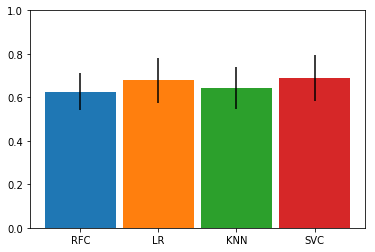

Best model: 
SVC
dim_reduction = PCA(copy=True, iterated_power='auto', n_components=20, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)
classifier__kernel = linear
classifier__C = 10
classifier__gamma = 0.001


In [48]:
print_results({
        "SVC" : grid_cv_svc_mri_oB,
        "LR" : grid_cv_lr_mri_oB,
        "RFC" : grid_cv_rfc_mri_oB,
        "KNN" : grid_cv_knn_mri_oB,
                  }, save_plot_to='openneuro_BIPOLAR_CONTROL.png')